#### Import Libraries

#### load Datasets

#### Data Preprocessing

E:\Anaconda Latest Install\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
E:\Anaconda Latest Install\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
E:\Anaconda Latest Install\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
E:\Anaconda Latest Install\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak o

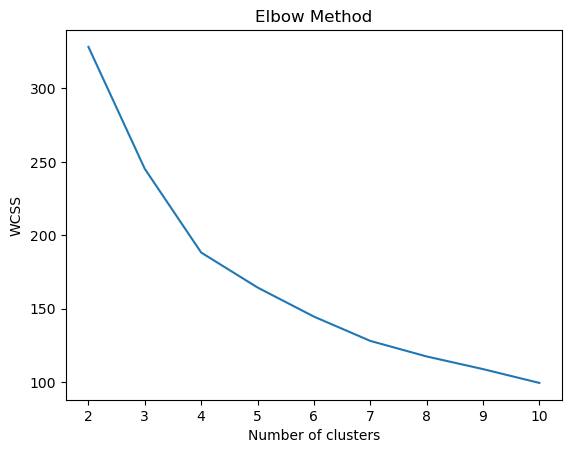

E:\Anaconda Latest Install\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
E:\Anaconda Latest Install\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
E:\Anaconda Latest Install\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
E:\Anaconda Latest Install\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak o

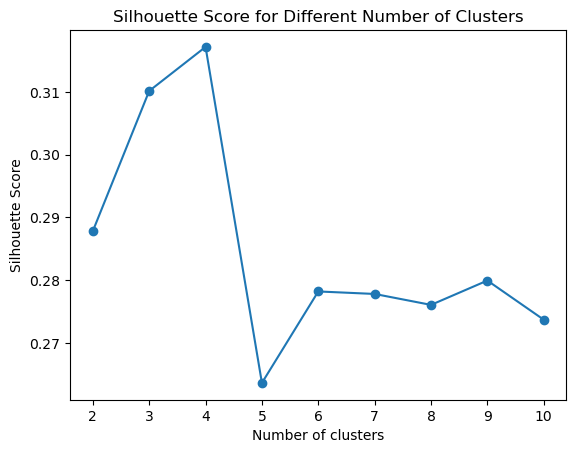

E:\Anaconda Latest Install\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Silhouette Score (KMeans): 0.28782486525955003
Davies-Bouldin Index (KMeans): 3.182909587144933


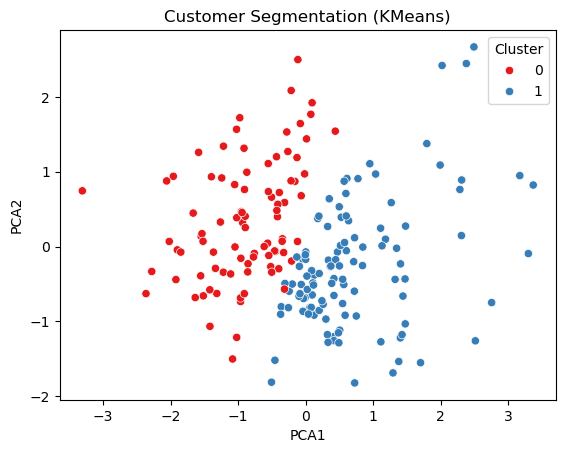

Number of Clusters: 2
Silhouette Score: 0.28782486525955003
Davies-Bouldin Index: 3.182909587144933


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, pairwise_distances
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Load your data
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

# Merge the datasets on CustomerID
data = pd.merge(customers, transactions, on='CustomerID')

# Feature engineering
data['TransactionDate'] = pd.to_datetime(data['TransactionDate'])

# Total spend per customer
customer_features = data.groupby('CustomerID').agg({
    'TotalValue': 'sum',               # Total spend
    'TransactionID': 'count',          # Frequency of transactions
    'TransactionDate': 'max'           # Last transaction date
}).reset_index()

# Recency feature: how many days since the last transaction
customer_features['Recency'] = (pd.to_datetime('today') - customer_features['TransactionDate']).dt.days

# Add an average transaction value feature
customer_features['AvgTransactionValue'] = customer_features['TotalValue'] / customer_features['TransactionID']

# Use RobustScaler to scale the features
scaler = RobustScaler()
scaled_features = scaler.fit_transform(customer_features[['TotalValue', 'TransactionID', 'Recency', 'AvgTransactionValue']])

# Step 1: Elbow Method (WCSS) to get a sense of the optimal number of clusters
wcss = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=500, n_init=15, random_state=42)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

plt.plot(range(2, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Step 2: Silhouette Score for different k values
silhouette_scores = []
for k in range(2, 11):  # Test with more clusters (2-10)
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=500, n_init=150, random_state=42)
    kmeans.fit(scaled_features)
    silhouette_avg = silhouette_score(scaled_features, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)

# Plot the Silhouette Scores
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Score for Different Number of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

# Step 3: Fit the KMeans model with the chosen number of clusters
optimal_clusters = 2  # You can choose this based on the Elbow plot and Silhouette Score
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=100, n_init=50, random_state=42)
customer_features['Cluster'] = kmeans.fit_predict(scaled_features)

# Evaluate the clustering with Silhouette Score
silhouette_avg = silhouette_score(scaled_features, customer_features['Cluster'])
print(f'Silhouette Score (KMeans): {silhouette_avg}')

# Step 4: Calculate the Davies-Bouldin Index
def davies_bouldin_index(X, labels):
    n_samples = X.shape[0]
    n_labels = len(np.unique(labels))
    dist = pairwise_distances(X)
    db_index = 0
    for i in range(n_labels):
        cluster_i = X[labels == i]
        dist_i = dist[labels == i][:, labels == i].mean()
        db_index += dist_i
    return db_index

db_index = davies_bouldin_index(scaled_features, customer_features['Cluster'])
print(f'Davies-Bouldin Index (KMeans): {db_index}')

# Step 5: Visualize the clusters using PCA for 2D visualization
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_features)

customer_features['PCA1'] = principal_components[:, 0]
customer_features['PCA2'] = principal_components[:, 1]

sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=customer_features, palette='Set1')
plt.title('Customer Segmentation (KMeans)')
plt.show()

# Deliverables: Summary Report of Results
print(f'Number of Clusters: {optimal_clusters}')
print(f'Silhouette Score: {silhouette_avg}')
print(f'Davies-Bouldin Index: {db_index}')
